In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
from util import plot_diff_lambdas_distances
%matplotlib inline

In [9]:
filename = 'data/ltb.csv'
df = pd.read_csv(filename)

In [10]:
# df.values
6.22435157e+02*8e-7

0.0004979481256

In [11]:
df[df.om_lambdas==0].count()
df.om_lambdas.nunique()
# df = df.head(2500)

50

In [12]:
# zs = np.linspace(0.2, 1, 50)
# z_lens = []
# for z in zs:
#     z_lens.extend([z]*50)

# df['z_lens'] = z_lens
# df['comoving_lens'] = df.DL*(1+df.z_lens)
# df['raw_rs'] = df.rs - df.comoving_lens
# df['M'] = 1474e12 / 3.086e22
# df.to_csv('data/diff_lambdas_bigger_redshifts2.csv', index=False)

In [25]:
length_scale = 3.086e22
# H_0 = 7.56e-27 * length_scale
H_0 = 70*1000/(3.086e22)/299792458 * length_scale # 70km/s/Mpc
# M_total = 1474e12 / length_scale

def omega_lambda2lambda(Omega_Lambda):
    return 3*Omega_Lambda*H_0**2

def kantowski_alpha(R, M, phi, Omega_Lambda):
    r0 = 1/(1/R + M/R**2 + 3/16*M**2/R**3)
    # r0 = 1/(1/R + M/R**2)
    # r0 = R*(1-M/R - 3/2*(M/R)**2 - 4*(M/R)**3)
    Lambda = omega_lambda2lambda(Omega_Lambda)
    rs = 2*M
    first_term = (rs/2/r0)*np.cos(phi)*(-4*(np.cos(phi))**2 - 12*np.cos(phi)*np.sin(phi)*np.sqrt(Lambda*r0**2/3+rs/r0*(np.sin(phi))**3) + Lambda*r0**2*(8/3-20/3*(np.sin(phi))**2))
    second_term = (rs/2/r0)**2*(15/4*(2*phi-np.pi) + np.cos(phi)*(4+33/2*np.sin(phi)-4*(np.sin(phi))**2+19*(np.sin(phi))**3-64*(np.sin(phi))**5) - 12*np.log(np.tan(phi/2))*(np.sin(phi))**3)
    return first_term + second_term


preds_first_order = []
preds_frw = []
preds_ishak = []
preds_kantowski = []
numerical_res = []
for index, row in df.iterrows():
    M_total = row.M
    Lambda = 3*row.om_lambdas*H_0**2
    enclosed_r = row.DL*row.theta
    rho_frw_initial = (1-row.om_lambdas)*3*H_0**2/(8*np.pi)
    r_h = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
    
    def mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return 4*np.pi*rho0*Rs**3*(np.log((Rs+r)/Rs) - r/(Rs+r))

    def rho(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return 0
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            rho0 = M_total/(4*np.pi*Rs**3*(np.log((Rs + rlimit)/Rs) - rlimit/(Rs + rlimit)))
            return rho0/(r/Rs)/(1 + r/Rs)**2

    def projected_mass(r):
        initial_rh = (3*M_total/(4*np.pi*rho_frw_initial))**(1./3)
        rlimit = initial_rh*0.5
        if r > rlimit:
            return M_total
        else:
            c = 10
            Rvir = rlimit/100
            Rs = Rvir/c
            
            g = 1/(np.log(1+c) - c/(1+c))
            Rtilde = r / Rvir
            if r > Rs:
                c_inverse = np.arccos(1/c/Rtilde)
            else:
                c_inverse = np.arccosh(1/c/Rtilde)
            return 1/(np.log(1+c*Rtilde) - c*Rtilde/(1+c*Rtilde))*mass(r)*(c_inverse/np.abs(c**2*Rtilde**2-1)**(1/2) + np.log(c*Rtilde/2))

    R = (row.DL*row.theta)
    M = projected_mass(enclosed_r)
    print(M, row.M)
    numerical = (row.raw_rs + row.comoving_lens)/row.raw_rs*row.theta
    
    A_frw = 4*M/R + 15*np.pi*M**2/4/R**2 + 401/12*M**3/R**3

    A_ishak = 4*M/R + 15*np.pi*M**2/4/R**2 + 305/12*M**3/R**3 - Lambda*R*row.exit_rhs/3

    A_kantowski = -kantowski_alpha(R, M, row.enter_phis, row.om_lambdas)
    
    
    preds_frw.append(A_frw/row.theta)
    preds_ishak.append(A_ishak/row.theta)
    preds_kantowski.append(A_kantowski/row.theta)
#     kant_higher_order_ratio.append(extra_term_ratio)
    numerical_res.append(numerical/row.theta)

df['preds_frw'] = preds_frw
df['preds_ishak'] = preds_ishak
df['preds_kantowski'] = preds_kantowski
# df['kant_higher_order_ratio'] = kant_higher_order_ratio
df['numerical_res'] = numerical_res

df['numerical'] = df.numerical_res/df.preds_frw - 1
df['ishak'] = df.preds_ishak/df.preds_frw - 1
df['kantowski'] = df.preds_kantowski/df.preds_frw - 1
df['numerical_kantowski'] = df.numerical_res / df.preds_kantowski - 1

4.7921385705e-08 4.7764095917e-07
4.78097325935e-08 4.7764095917e-07
4.76948815282e-08 4.7764095917e-07
4.75760650305e-08 4.7764095917e-07
4.74530859485e-08 4.7764095917e-07
4.73257334463e-08 4.7764095917e-07
4.71937817692e-08 4.7764095917e-07
4.70569888578e-08 4.7764095917e-07
4.69150948001e-08 4.7764095917e-07
4.67678200986e-08 4.7764095917e-07
4.66148637255e-08 4.7764095917e-07
4.64559009345e-08 4.7764095917e-07
4.62905807921e-08 4.7764095917e-07
4.6118523384e-08 4.7764095917e-07
4.59393166444e-08 4.7764095917e-07
4.57525127462e-08 4.7764095917e-07
4.55576239767e-08 4.7764095917e-07
4.53541180092e-08 4.7764095917e-07
4.51414124615e-08 4.7764095917e-07
4.49188686088e-08 4.7764095917e-07
4.46857840887e-08 4.7764095917e-07
4.44413843983e-08 4.7764095917e-07
4.41848129365e-08 4.7764095917e-07
4.39151192818e-08 4.7764095917e-07
4.36312453176e-08 4.7764095917e-07
4.33320087131e-08 4.7764095917e-07
4.30160831291e-08 4.7764095917e-07
4.26819743396e-08 4.7764095917e-07
4.23279912086e-08 4.77

In [17]:
df.head()

,DL,M,alphas,comoving_lens,enter_phis,exit_rhs,om_ks,om_lambdas,raw_rs,step,theta,z_lens,preds_frw,preds_ishak,numerical,ishak,preds_kantowski,numerical_res,kantowski,numerical_kantowski
0,1047.865544,4.776410e-07,0.000075,1571.798316,0.001394,1.732834,0,0.000000,52.164928,1.000000e-07,0.000002,0.5,31.132939,31.132939,-0.000052,-7.118157e-10,31.132843,31.131323,-0.000003,-0.000049
1,1052.237748,4.776410e-07,0.000075,1578.356622,0.001391,1.744663,0,0.020204,52.734752,1.000000e-07,0.000002,0.5,30.931703,30.931701,-0.000052,-6.607820e-08,30.931609,30.930104,-0.000003,-0.000049
2,1056.678873,4.776410e-07,0.000074,1585.018310,0.001387,1.756822,0,0.040408,53.320745,1.000000e-07,0.000002,0.5,30.727693,30.727689,-0.000052,-1.337893e-07,30.727599,30.726110,-0.000003,-0.000048
3,1061.190926,4.776410e-07,0.000074,1591.786389,0.001383,1.769328,0,0.060612,53.923693,1.000000e-07,0.000002,0.5,30.520806,30.520799,-0.000051,-2.039764e-07,30.520713,30.519239,-0.000003,-0.000048
4,1065.775999,4.776410e-07,0.000073,1598.663999,0.001380,1.782197,0,0.080816,54.544440,1.000000e-07,0.000002,0.5,30.310934,30.310926,-0.000051,-2.767809e-07,30.310843,30.309385,-0.000003,-0.000048


In [29]:
stats = df[['om_lambdas', 'numerical', 'ishak', 'kantowski', 'numerical_kantowski']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
# stats = df[['om_lambdas', 'om_ks', 'numerical', 'ishak', 'kantowski', 'numerical_kantowski', 'kant_higher_order_ratio']].groupby('om_ks').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['numerical mean std'] = stats['numerical std']/np.sqrt(stats['numerical count'])
stats['numerical_kantowski mean std'] = stats['numerical_kantowski std'] / np.sqrt(stats['numerical_kantowski count'])
# stats['numerical first order mean std'] = stats['numerical first order std']/np.sqrt(stats['numerical first order count'])
stats['ishak mean std'] = stats['ishak std']/np.sqrt(stats['ishak count'])
stats.head()

,numerical mean,numerical std,numerical count,ishak mean,ishak std,ishak count,kantowski mean,kantowski std,kantowski count,numerical_kantowski mean,numerical_kantowski std,numerical_kantowski count,numerical mean std,numerical_kantowski mean std,ishak mean std
om_lambdas,,,,,,,,,,,,,,,
0.000000,-0.000047,NaN,1,-7.118096e-10,NaN,1,-0.000003,NaN,1,-0.000044,NaN,1,NaN,NaN,NaN
0.020204,-0.000035,NaN,1,-6.607926e-08,NaN,1,-0.000003,NaN,1,-0.000032,NaN,1,NaN,NaN,NaN
0.040408,-0.000035,NaN,1,-1.337915e-07,NaN,1,-0.000003,NaN,1,-0.000032,NaN,1,NaN,NaN,NaN
0.060612,-0.000035,NaN,1,-2.039797e-07,NaN,1,-0.000003,NaN,1,-0.000032,NaN,1,NaN,NaN,NaN
0.080816,-0.000035,NaN,1,-2.767854e-07,NaN,1,-0.000003,NaN,1,-0.000032,NaN,1,NaN,NaN,NaN


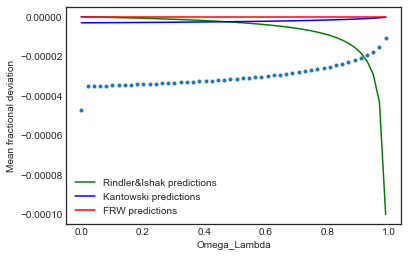

In [30]:
scale = 1
# stats = stats.head(49)
plt.plot(stats.index, stats['numerical mean']/scale, '.', label='__nolegend__')
# plt.plot(stats.index, stats['numerical first order mean']/scale, 'b-', label='with second order corrections')
# plt.errorbar(stats.index, stats['numerical mean']/scale, yerr=stats['numerical mean std']/scale, linestyle='none', label='__nolegend__')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean fractional deviation')
plt.plot(stats.index, stats['ishak mean']/scale, 'g-', label='Rindler&Ishak predictions')
plt.plot(stats.index, stats['kantowski mean']/scale, 'b-', label="Kantowski predictions")
plt.plot(stats.index, [0/scale]*len(stats.index), 'r-', label='FRW predictions')
# plt.ylim((-0.0008, 0.0008))
plt.legend()
# plt.savefig('images/half_analytical.png',  dpi=400)